# DeepLabV3 VOC 2012 and SBD 

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import my_datasets as mdset
import eval_train as ev
from utils import * 




## Dataset : Pascal VOC 2012

In [2]:
dataroot_voc = '/data/voc2012'
dataroot_sbd = '/data/sbd'
model_name = 'dlv3_voc_sbd_semisup_g05.pt'
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,model_name)
batch_size = 2


In [3]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', download=True)
val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [4]:
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation')

### Concatene Dataset

In [5]:
train_dataset_unsup = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])

### Split dataset

In [6]:
train_dataset_sup = split_dataset(train_dataset_unsup,0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([500, 500, 3])


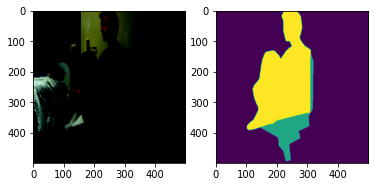

torch.Size([500, 500])

In [7]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = train_dataset_sup.__getitem__(0)
image, mask = sample[0], sample[1]
#print(type(image))
#print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [8]:
dataloader_train_sup = torch.utils.data.DataLoader(train_dataset_sup, batch_size=batch_size,\
                                                       shuffle=True,drop_last=True)
dataloader_train_unsup = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
                                                     shuffle=True,drop_last=True)

dataloader_val = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [9]:
print("Taille dataset train supervised :",len(train_dataset_sup))
print("Taille dataset train unsupervised :",len(train_dataset_unsup))
print("Taille dataset val VOC :",len(val_dataset_VOC))

Taille dataset train supervised : 2126
Taille dataset train unsupervised : 7087
Taille dataset val VOC : 1449



## DeepLabV3 Pytorch

In [10]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Training

In [11]:
#backward_step = 4
learning_rate = 0.007
moment = 0.9
wd = 1e-4
n_epochs = 26
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
angle_max = 30
gamma = 0.5
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / ((len(dataloader_train_sup)*2) * n_epochs)) ** 0.9)


#writer = SummaryWriter()
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
criterion_unsupervised = nn.KLDivLoss(reduction='batchmean')

In [12]:
#cpt = 0 # cpt for backward every backward_step
iou_train = []
iou_test = []
combine_loss_train = []
combine_loss_test = []
loss_train_unsup = []
loss_train_sup = []
loss_test = []
pix_accuracy = []
accuracy_test = []
#
all_combine_loss_train = []
all_loss_train_sup = []
all_loss_train_unsup = []
all_iou_train= []
all_pix_accuracy =  []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)
    model.train()

    for batch_sup,batch_unsup in zip(dataloader_train_sup,dataloader_train_unsup):
        optimizer.zero_grad()
        if random.random() > 0.5: # I use this to rotate the image on the left and on the right during training.
            angle = np.random.randint(0,angle_max)
        else:
            angle = np.random.randint(360-angle_max,360)
        x_unsup,_ = batch_unsup
        loss_equiv,acc = compute_transformations_batch(x_unsup,model,angle,reshape=False,\
                                                     criterion=criterion_unsupervised,device=device)
        x,mask = batch_sup
        x = x.to(device)
        mask = mask.to(device)
        pred = model(x)["out"]
        loss_equiv = loss_equiv / (pred.size()[2]*pred.size()[3]) # divide by the number of pixel in the prediction
        loss_equiv = loss_equiv.to(device) # otherwise bug in combining the loss 
        loss_sup = criterion_supervised(pred,mask)
        loss = gamma*loss_sup + (1-gamma)*loss_equiv # combine loss              
        loss.backward()
        optimizer.step()

        # append for plot
        all_pix_accuracy.append(acc) # accuracy between the original mask and the transform mask put back in place
        all_loss_train_unsup.append(loss_equiv.item())
        all_loss_train_sup.append(loss_sup.item())
        all_combine_loss_train.append(loss.item())
            
    lr_scheduler.step()
    #
    m_loss_combine = np.array(all_combine_loss_train).mean()
    m_acc = np.array(all_pix_accuracy).mean()
    combine_loss_train.append(m_loss_combine)
    pix_accuracy.append(m_acc)
    loss_train_sup.append(np.array(all_loss_train_sup).mean())
    loss_train_unsup.append(np.array(all_loss_train_unsup).mean())

    all_pix_accuracy = []
    all_loss_train_unsup = []
    all_loss_train_sup = []
    all_combine_loss_train = []
    print("loss sup :",loss_sup.item(),"loss unsup",loss_equiv.item(),"loss",loss.item()) 
    print("EP:",ep," combine loss train:",m_loss_combine," pixel accuracy between masks ",m_acc)

    ## Evaluate the  model
    model.eval()
    state = ev.eval_iou(model,dataloader_val,device=device,num_classes=21,batch_size=batch_size)
    iou = state.metrics['mean IoU']
    acc = state.metrics['accuracy']
    loss = state.metrics['CE Loss']
    print('EP:',ep,'iou:',state.metrics['mean IoU'],\
          'Accuracy:',state.metrics['accuracy'],'Loss CE',state.metrics['CE Loss'])
    loss_test.append(loss)
    iou_test.append(iou)
    accuracy_test.append(acc)

    torch.save(model,save)
    


EPOCH 0


/workspace/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:158: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


loss sup : 0.26506510376930237 loss unsup 0.06272346526384354 loss 0.16389428079128265
EP: 0  combine loss train: 0.5253431289014341  pixel accuracy between masks  0.9410493979303857
EP: 0 iou: 0.2823391376522005 Accuracy: 0.7934446608727163 Loss CE 0.6938509859962246
EPOCH 1
loss sup : 0.642034113407135 loss unsup 0.03131077438592911 loss 0.33667245507240295
EP: 1  combine loss train: 0.4328313096376488  pixel accuracy between masks  0.9348823951081844
EP: 1 iou: 0.34643441858582763 Accuracy: 0.7955819749568749 Loss CE 0.6783549032534625
EPOCH 2
loss sup : 0.5721280574798584 loss unsup 0.046235233545303345 loss 0.3091816306114197
EP: 2  combine loss train: 0.40288098498492003  pixel accuracy between masks  0.9301699435559736
EP: 2 iou: 0.25051169361440445 Accuracy: 0.7287924399900884 Loss CE 1.026379632016064
EPOCH 3
loss sup : 0.6594168543815613 loss unsup 0.04685469716787338 loss 0.35313576459884644
EP: 3  combine loss train: 0.35546195143281795  pixel accuracy between masks  0.9316

## Plot

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Combine loss train")
plt.plot(combine_loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Cross entropy loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Equivariance loss train")
plt.plot(loss_train_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Accuracy train between rotated prediction and original prediction")
plt.plot(pix_accuracy)
plt.xlabel("iterations")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Mean iou train ")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [ ]:
torch.save(model,save)